# Data Collection

https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv
https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2013

In [649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import pickle

import scipy.stats as st

In [5]:
ls DATA/

demographic.csv    examination.csv    medications.csv
diet.csv           labs.csv           questionnaire.csv


In [671]:
demo = pd.read_csv("DATA/demographic.csv")
exam = pd.read_csv("DATA/examination.csv")
medi = pd.read_csv("DATA/medications.csv", engine ='python')
diet = pd.read_csv("DATA/diet.csv")
labs = pd.read_csv("DATA/labs.csv")
ques = pd.read_csv("DATA/questionnaire.csv")

In [672]:
# Merge dataframes
df = demo.merge(exam, on='SEQN').merge(medi, on='SEQN').merge(
    diet, on='SEQN').merge(labs, on='SEQN').merge(ques, on='SEQN')


In [673]:
df = df.drop_duplicates(subset = 'SEQN')

# Dependent Variable (DV)
What I am interested in is learning the factors that affect the mental health and depressive symptoms the most. To gauge this, I will create a mental health index as DV, using the scores from the questionnaires under Mental Health - Depression Screener section. I'll also narrow down the subjects to those who have answered to have experienced at least some level of depressive symptoms. (Because we are interested in knowing how to prevent people with mental health concerns to develop serious symptoms, not about mental health of general population.)

First I'll eliminate the subjects entirely missing these scores, since we don't have any measure to infer these data. But if only some of these columns are missing, we will infer from other answers they provided.  

In [674]:
# select only depression screener columns and subject number
cols = ['SEQN'] + [c for c in df.columns if c.startswith('DPQ')]
DPQ = df.loc[:, cols]
DPQ.SEQN = DPQ.SEQN.apply(lambda x: str(x))

In [675]:
DPQ.describe()

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
count,5398.000000,5396.000000,5395.000000,5395.000000,5395.000000,5394.000000,5394.000000,5394.000000,5393.000000,3674.000000
mean,0.415895,0.367865,0.618536,0.770714,0.397961,0.271598,0.289952,0.180200,0.056555,0.348122
std,0.833711,0.774571,0.964800,0.942682,0.802593,0.702979,0.722671,0.589614,0.367381,0.682270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,9.000000,7.000000,7.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


### Data transformation 
7 is Refused to answer and 9 is don't know.  So we will turn these into nan values. 

In [676]:
DPQ = DPQ.replace(7, np.nan)
DPQ = DPQ.replace(9, np.nan)


### Missing sub-value for DV 
Each questions are rated at same scale (0-3).  

DPQ100 is conditional to have answered high on other columns (If responded to any of the other question with 1, 2 or 3) So we can safely assume that if only this value is missing, it means 0. 

If more than half of these columns (exc. DPQ100, >= 5) are missing, we will drop the subject. Otherwise, we will figure out a way to infer the measures.

In [677]:
# If DPQ100 is missing, replace it with 0.
DPQ.DPQ100 = DPQ.DPQ100.replace(np.nan, 0)

In [678]:
# If there are more than half columns missing, drop the subject.
DPQ = DPQ.drop(DPQ[DPQ.isnull().sum(axis = 1) > 4].index, axis = 0)

In [679]:
# look at the columns with missing values
DPQ.isnull().sum()

SEQN      0
DPQ010    5
DPQ020    5
DPQ030    1
DPQ040    1
DPQ050    2
DPQ060    5
DPQ070    4
DPQ080    4
DPQ090    5
DPQ100    0
dtype: int64

There are some missing values. We will replace it with the highest correlated column value.

In [680]:
# select the value that correlates the most with each columns
tmp = DPQ.dropna().iloc[:, 1:10]
cols = list(DPQ.columns)[1:10]
cor_dict = {}
for c in cols: 
    Y = tmp[c]
    X = tmp.drop(c, axis = 1)
    corr_ = X.corrwith(Y)
    max_ = corr_[corr_ == max(corr_)]
    cor_dict[c] = (list(max_.index)[0], max_[0])

In [681]:
cor_dict

{'DPQ010': ('DPQ020', 0.5317926404418502),
 'DPQ020': ('DPQ060', 0.5933182662318698),
 'DPQ030': ('DPQ040', 0.5156076939700797),
 'DPQ040': ('DPQ030', 0.5156076939700797),
 'DPQ050': ('DPQ040', 0.4471370380967231),
 'DPQ060': ('DPQ020', 0.5933182662318698),
 'DPQ070': ('DPQ020', 0.4508314640526112),
 'DPQ080': ('DPQ070', 0.4440335632622107),
 'DPQ090': ('DPQ060', 0.4098166450969543)}

In [682]:
# fill NA with the value from highest correlated questionnarie
for k, v in cor_dict.items():
    DPQ[k] = DPQ[k].fillna(DPQ[v[0]])

In [683]:
# there are a few that could not be filled (probably because both variables were empty). 
# There aren't that many so I'll drop these ones.
DPQ = DPQ.dropna(axis = 0)

In [473]:
# Fill the rest of missing values with the row means
# DPQ = DPQ.T.fillna(DPQ.mean(axis=1)).T

## Add MH_Index
The real DV I'm interested in is the total score of these measures, which I will call "MH_Index (Mental Health Index)". 
I'm using the total score instead of mean, because even though I believe each questin weighs differently in terms of how much it contributes to the idea of mental health (suicidal thought should weigh more than feeling tired), but I don't want to take the liberty of assigning these weights myself. 

In [684]:
# sum of each row as MH_Index
DPQ['MH_Index'] = DPQ.sum(axis = 1)

## Subsetting dataset
The ultimate purpose of my research is to reduce suicide rate. So I'm interested in what factors may affect the people to go from depressive symptom to suicidal thouoght. So participants who answered to not feel depressed at all are not relevant to this question. Including them may also potentially skew the model and weaken the relationship to factors that has stronger influence on people with some depressive symptoms. So I'll remove these participants. 

In [685]:
DPQ = DPQ[DPQ.DPQ020 != 0]

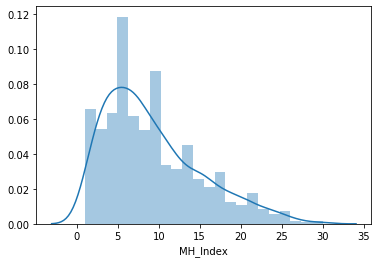

In [686]:
sns.distplot(DPQ['MH_Index'])

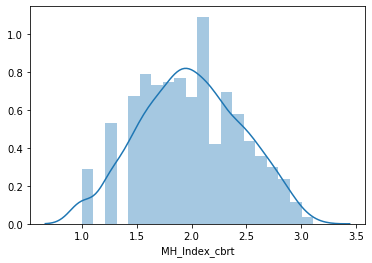

In [687]:
# log transformation
DPQ['MH_Index_cbrt'] = np.cbrt(DPQ.MH_Index)
sns.distplot(DPQ['MH_Index_cbrt'])


## DPQ.MH_Index (or ln) is the DV.

#### Interpretting log transformed DV

https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/
   
"Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. Example: the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9. For every one-unit increase in the independent variable, our dependent variable increases by about 22%."
    

# Selecting Independent Variables
There are over 1500 measures here. It won't make sense to run with all of these measures. So I will narrow down to topics that I think is important. 

**Topics I'll look at**
0. General Demographics
    - Age
    - Gender
    - Race
    - Sexual Identity
    - Income
    - Household (Family size)
    - Emplyment Status / Occupation (OCQ)
    - Education level 
    - Veterans
1. Existing Conditions
    - Disability (DLQ)
    - Physical Functioning (PFQ)
    - Medical Conditions (MCQ)
    - Sleep (SLQ)
2. Hormone Level
    - maybe. 
3. Accessibility to Care
    - Visit to health care professional (HUQ061)
    - Visit to mental health professional (HUQ090)
4. Lifestyle (ability to maintain)
    - Physical Activity (PAQ)
    - Food security (FSQ)
5. Diet & Nutrition (CBQ/DBQ)
6. Substance Abuse (DUQ, ALQ)
7. Pregnancy


## Demographics
Age: RIDAGEYR (in year, capped at 80)  
Gender: RIAGENDR (1: male, 2: female)  
Family Income: INDFMIN2  
Income to poverty guideline : INDFMPIR  
number of people in the household : DMDHHSIZ  
Veterans : DMQMILIZ  
Sexual Identity: SXQ294   
- Heterosexual or straight (attracted to men)  1  
    Homosexual or lesbian (attracted to women) 2  
    Bisexual (attracted to men and women)  3  
    Something else 4  
    Not sure 5  
    REFUSED  7  
    DON'T KNOW  9  
Education level: DMDHREDU  
 

In [851]:
df.SEQN = df.SEQN.astype('str')

In [852]:
# merge DV to narrow down the subjects
MHI = DPQ[['SEQN', 'MH_Index', 'MH_Index_cbrt']]
select_df = MHI.merge(df, on ="SEQN")

In [853]:
# changing variable name to somethign more intuitive
select_df = select_df.rename(columns = {"RIDAGEYR":"age", 
                                       "RIAGENDR": "gender", 
                                        "DMDHHSIZ": "total_household", 
                                       "INDFMIN2": "income",
                                       "DMDHREDU": "education"})

### Age
Survey age was capped at 80, meaning age of anyone older was inputted as 80. To adapt to this, I'll add some noise to this data by dispersing the data with age 80 to be random integer between 80 to 90.  
Otherwise we see that it's heavy on 18 years old, and rest are more or less noisy.  

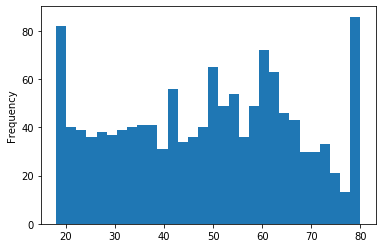

In [854]:
select_df.age.plot(kind = 'hist', bins = 30)

In [855]:
select_df.age = select_df.age.apply(lambda x: np.random.randint(80, 90, 1)[0] if x == 80 else x)

In [856]:
select_df.age.isnull().sum()

0

### Gender
63% of the sample are female. 

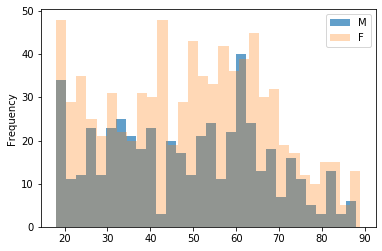

In [857]:
select_df.age[select_df.gender == 1].plot(kind = 'hist', bins = 30, alpha = 0.7, label = "M")
select_df.age[select_df.gender == 2].plot(kind = 'hist', bins = 30, alpha = 0.3, label = "F")
plt.legend()

In [858]:
select_df.gender.value_counts(normalize = True)

2    0.62803
1    0.37197
Name: gender, dtype: float64

In [859]:
select_df.gender.isnull().sum()

0

### Total number of household
Most households have 2 people, followed by 3, 1, 4.

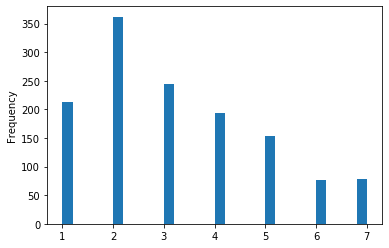

In [860]:
select_df.total_household.plot(kind = 'hist', bins = 30)

In [861]:
select_df.total_household.value_counts(normalize = True)

2    0.274242
3    0.184848
1    0.161364
4    0.146212
5    0.116667
7    0.059091
6    0.057576
Name: total_household, dtype: float64

In [862]:
select_df.total_household.isnull().sum()

0

#### Household types
I want to know in detail different household types. Single mom and a couple are both two people households but their living situation can be very different. I'll create a new feature "n_dependents" and add up all children numbers (under 5 or under 17). Then add a new feature "n_adults", a household number subtracting children number.

In [863]:
select_df['n_dependents'] = select_df['DMDHHSZA'] + select_df['DMDHHSZB']
select_df['n_adults'] = select_df['total_household'] - select_df['n_dependents']
select_df.n_adults.value_counts()

2    551
3    273
1    266
4    154
5     46
7     17
6     12
0      1
Name: n_adults, dtype: int64

### Income (Total household income as a range value in dollars)
They are tiered. I'll put the mean value of the interval.

In [864]:
cond = [
    select_df.income == 1, 
    select_df.income == 2, 
    select_df.income == 3, 
    select_df.income == 4, 
    select_df.income == 5, 
    select_df.income == 6, 
    select_df.income == 7, 
    select_df.income == 8, 
    select_df.income == 9, 
    select_df.income == 10, 
    select_df.income == 12, 
    select_df.income == 13, 
    select_df.income == 14, 
    select_df.income == 15 
]
vals = [np.mean([0, 4999]), np.mean([5000, 9999]), np.mean([10000, 14999]), 
       np.mean([15000, 19999]), np.mean([20000, 24999]), np.mean([25000, 34999]), 
       np.mean([35000, 44999]), np.mean([45000, 54999]), np.mean([55000, 64999]), 
       np.mean([65000, 74999]), np.mean([20000, 40000]), np.mean([0, 20000]), 
       np.mean([75000, 99999]), np.mean([100000, 200000])]

select_df['income_avg'] = np.select(cond, vals, np.nan)

In [865]:
select_df.corrwith(select_df.income_avg).sort_values(ascending = False)[0:20]

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


income_avg    1.000000
MCQ240J       1.000000
OSD110E       1.000000
OSD110C       1.000000
MCQ240T       1.000000
OSQ090E       0.977140
RHQ602Q       0.960769
income        0.894650
INDFMPIR      0.873786
INDFMMPI      0.773866
SMQ740        0.757460
DBQ390        0.745770
OSD050AB      0.730409
INDHHIN2      0.630805
PHASUPMN      0.538625
OSD050BA      0.470817
DMDHSEDU      0.459129
FSD650ZW      0.457924
DBQ400        0.445106
OSD050CA      0.434811
dtype: float64

In [866]:
select_df.income_avg.isnull().sum()

57

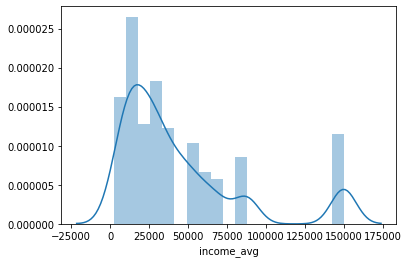

In [867]:
sns.distplot(select_df.income_avg[~select_df.income_avg.isnull()])

no other correlated measures have enough data to infer the missing vlaues.
Since distribution is skewed, I'll put median for misisng incomes.

In [868]:
select_df.income_avg = select_df.income_avg.fillna(np.median(select_df.income_avg[~select_df.income_avg.isnull()]))

In [921]:
# adding log transformation to even out the skew
select_df['income_avg_ln'] = np.log(select_df.income_avg)

### Marital Status
Instead of dropping nan values, I'll add a new category 'others', for people who decided not to answer or 'don't know' the answer. 

In [664]:
select_df.income.isnull().sum()

16

In [873]:
select_df['marital_st'] = np.where((select_df.DMDHRMAR == 77) | (select_df.DMDHRMAR == 77) | (select_df.DMDHRMAR.isnull()), 
         0, select_df.DMDHRMAR)

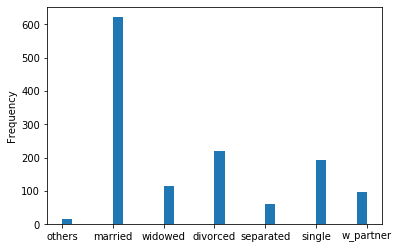

In [882]:
select_df.marital_st.plot(kind = 'hist', bins = 30)
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           labels = ['others', 'married', 'widowed', 'divorced', 
                    'separated', 'single', 'w_partner'])
plt.show()

In [874]:
select_df.marital_st.value_counts()

1.0    621
3.0    219
5.0    194
2.0    115
6.0     96
4.0     60
0.0     15
Name: marital_st, dtype: int64

In [875]:
select_df.marital_st.isnull().sum()

0

### Veterans
I will combine veterans from US and foreign countries to create a binary column veteran.

In [876]:
select_df['veteran'] = np.where((select_df.DMQADFC == 1) | (select_df.DMQMILIZ == 1), 
        1, 0)

### Education
There are separate questions for people age 20+, and for 18, 19 years olds. I'll combine them to create a collective category.

In [896]:
cond = [(select_df.DMDEDUC2.isnull()) & ((select_df.DMDEDUC3 < 10) | (select_df.DMDEDUC3 == 66)  | (select_df.DMDEDUC3 == 55)),
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 < 12),#Some HS or less
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 <= 14),#HS & GED
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 == 15)#Some col
       ]
vals = [1, 2, 3, 4]
select_df['education'] = np.select(cond, vals, select_df.DMDEDUC2)


In [897]:
select_df.education.value_counts()

4.0    407
3.0    325
2.0    238
5.0    234
1.0    116
Name: education, dtype: int64

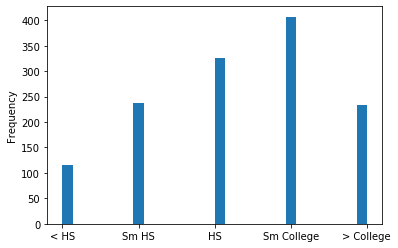

In [900]:
select_df.education.plot(kind = 'hist', bins = 30)
plt.xticks([1, 2, 3, 4, 5], 
           labels = ['< HS', 'Sm HS', 'HS', 'Sm College', '> College'])
plt.show()

### US Born

In [903]:
select_df.DMDBORN4.value_counts()

1     974
2     345
77      1
Name: DMDBORN4, dtype: int64

No way to infer why one person refused to answer, so I'll drop that person.

In [906]:
select_df['US_born'] = np.where(select_df.DMDBORN4 == 77, 
                             np.nan, select_df.DMDBORN4)

### Length in US
Tirered, I'll keep them as is for now, and treat the missing and refused to answer values as one category.

In [909]:
select_df['Length_US'] = np.where((select_df.DMDYRSUS == 77) | (select_df.DMDYRSUS == 99) | (select_df.DMDYRSUS.isnull()), 
                             0, select_df.DMDYRSUS)

## Plotting Relationship
I'll plot relationship and build a baseline model from these demographics data first.

In [912]:
# for each columns, plot scatter plot
def mass_scatter(df, y = 'MH_Index'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, 
                             figsize = (12, 12))

    axes = axes.ravel()

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

In [922]:
cols = ['MH_Index', 'gender', 'age', 'education', 'total_household', 
        'n_dependents', 'n_adults', 'income_avg_ln', 'marital_st', 
        'veteran', 'US_born', 'Length_US']

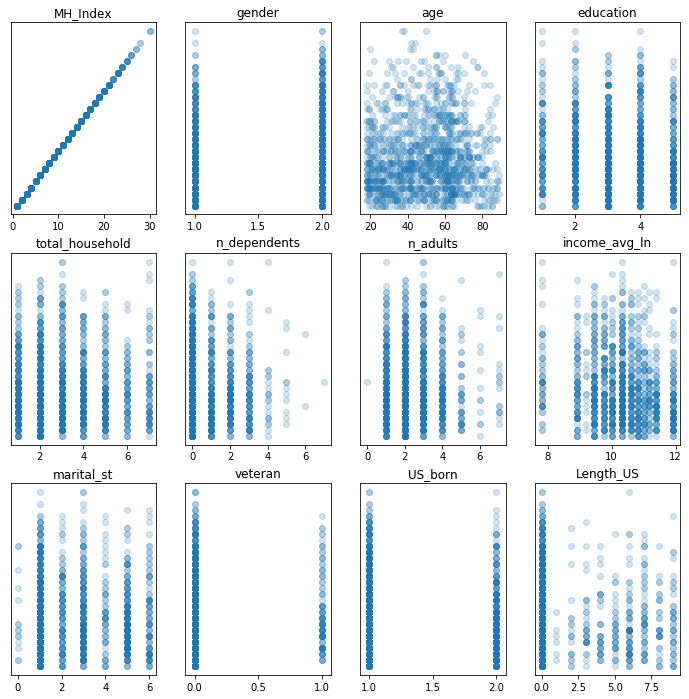

In [923]:
mass_scatter(select_df[cols])

# Baseline Model


In [ ]:
# availability of health care/frequency of visits compared to the 